In [2]:
%matplotlib inline

import random
import torch
from d2l import torch as d2l

#### 根据带有噪声的线性模型构造一个人造的数据集。使用线性模型参数w = [2, -3, 4]<sup>T</sup>、b = 4.2 和噪声项ε 生成数据集及其标签：</br> w 为权重； b 为偏差
y = Xw + b +ε

In [3]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b  # matmul 矩阵相乘（行与列元素，相乘相加）

    y += torch.normal(0, 0.01, y.shape)  # 均值为0，方差为0.01的 噪声
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 10000)

In [5]:
features, labels

(tensor([[ 2.1216,  0.8780],
         [-0.4799,  1.5934],
         [ 0.2614,  0.3997],
         ...,
         [ 0.5102,  0.1278],
         [ 0.1083, -0.4859],
         [ 1.4546, -0.5569]]),
 tensor([[ 5.4786],
         [-2.1799],
         [ 3.3902],
         ...,
         [ 4.7922],
         [ 6.0628],
         [ 9.0198]]))

#### `features` 中的每一行都包含一个二维数据样本，lables中的每一行都含有一维标签值（一个标量)

In [11]:
print('features:', features[0], '\nlabels：', labels[0])

features: tensor([2.1216, 0.8780]) 
labels： tensor([5.4786])


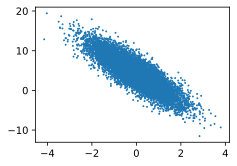

In [6]:
d2l.set_figsize()
# 需要执行detach()才能转numpy
# detach() 
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

#### 定义一个`data_iter`函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量

In [14]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)  # 样本个数, 获取第一维个数
    print(num_examples)
    indices = list(range(num_examples))  # [0, ... , 9999]
    random.shuffle(indices)  # 将样本打乱，进行随机读取
    
    for i in range(0, num_examples, batch_size):   # 生成器 for 循环上面的部分只执行一次
        batch_indices = torch.tensor(
            indices[i:min(i+batch_size, num_examples)]
        )
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

10000
tensor([[ 0.0125,  0.1818],
        [-0.0159, -0.3813],
        [ 1.1996,  0.0387],
        [-0.3318,  1.3611],
        [-1.1223, -0.3581],
        [-0.2353,  0.0974],
        [-0.6728, -0.3637],
        [ 0.5361,  1.0120],
        [-0.3505, -1.5368],
        [ 1.0878, -0.4618]]) 
 tensor([[ 3.5939],
        [ 5.4694],
        [ 6.4719],
        [-1.0909],
        [ 3.1665],
        [ 3.3910],
        [ 4.0706],
        [ 1.8393],
        [ 8.7206],
        [ 7.9395]])


#### 定义初始化模型参数  && 定义模型


In [73]:
w = torch.normal(0, 0.1, size=(2, 1), requires_grad=True) # requires_grad 计算梯度

b = torch.zeros(1, requires_grad=True)  # b为偏差

print(w, b)

tensor([[-0.0364],
        [ 0.1333]], requires_grad=True) tensor([0.], requires_grad=True)


In [35]:
def line_regression(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

#### 定义损失函数


In [36]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (1/2) * ((y_hat - y) ** 2)

#### 定义优化算法

随机梯度下降，随机是说随机采样，公式如图：
![image-20211020212323299](https://i.loli.net/2021/10/20/2Xv9N8ZAUaFjgId.png)

小批量随机梯度下降 （除以样本个数)

In [56]:
def sgd(params:list, lr, batch_size):  # parmas 模型参数，lr 学习率， 
    """小批量随机梯度下降"""

    with torch.no_grad():  # 不需要进行梯度
        for param in params:
            param -= (lr * param.grad / batch_size)  #  lr * param.grad 为学习率乘以梯度；除batch_size 是损失函数取均值，对损失函数除以n，或者在这里对学习率除以n都可以。
            param.grad.zero_()  # 手动的将梯度设置为0，用于下次循环的计算

#### 训练过程

In [74]:
lr = 0.03
num_epochs = 3  # 数据扫3遍
net = line_regression  # 线性回归模型

loss = squared_loss  # 损失函数


for epoch in range(num_epochs): 
    for X, y in data_iter(batch_size, features, labels):  # 每次取batch_size的X和y
        y_hat = net(X, w, b)
        l = loss(y_hat, y)
        l.sum().backward()  # 反向传播，该方法对网络中所有权重计算损失函数的梯度。这个梯度会反馈给最优化方法，用来更新权值以最小化损失函数

        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新w和b

    with torch.no_grad():
        train_1 = loss(net(features, w, b), labels)  # 整个数据feature和labels计算损失函数
        print(f'epochs {epoch + 1}, loss {float(train_1.mean()):f}')  # float输出


10000
epochs 1, loss 0.000049
10000
epochs 2, loss 0.000049
10000
epochs 3, loss 0.000049


## 线性回归简洁实现

### 使用深度学习框架实现线性回归模型

In [78]:
import numpy as np
import torch

from torch.utils import data
from d2l import torch as d2l 

true_w = torch.tensor([2., -3.4])
true_b = 4.2

features, labels = d2l.synthetic_data(true_w, true_b, num_examples=10000)
print(features, labels)

tensor([[ 1.2325,  0.7815],
        [-2.4504,  0.5105],
        [-1.5348,  1.1580],
        ...,
        [ 2.2886, -1.3594],
        [ 0.1299, -0.0339],
        [ 0.5116,  1.5197]]) tensor([[ 4.0141],
        [-2.4316],
        [-2.8213],
        ...,
        [13.4119],
        [ 4.5922],
        [ 0.0736]])


### 使用框架的API读取数据

In [88]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个Pytorch 数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)  # 参数为 多个tensor
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)  # 返回可迭代对象


next(iter(data_iter))

[tensor([[-1.0111, -0.2608],
         [ 1.3625, -0.5680],
         [-0.2215,  1.1575],
         [ 0.8247,  0.1937],
         [-1.3399,  0.7639],
         [ 0.2569, -0.2038],
         [ 1.5832, -1.4965],
         [-1.0062,  0.9404],
         [ 1.2361, -0.8391],
         [-0.1954, -1.1298]]),
 tensor([[ 3.0477],
         [ 8.8748],
         [-0.1747],
         [ 5.1899],
         [-1.0702],
         [ 5.4066],
         [12.4683],
         [-1.0040],
         [ 9.5268],
         [ 7.6706]])]

### 模型的定义  -  使用框架的预定义好的层

In [92]:
from torch import nn  # nn是神经网络的缩写

# in_features由输入张量的形状决定，out_features则决定了输出张量的形状 
net = nn.Sequential(nn.Linear(2, 1))  # 把模型放到Sequential的容器中 



### 初始化模型参数 w 和b

In [93]:
net[0].weight.data.normal_(0, 0.01)  # 设置w。  net[0].weight 为用于梯度计算的w
net[0].bias.data.fill_(0)  #  填充b为0。 net[0].bias 填充0

tensor([0.])

### 计算均方误差，这里使用MSELoss类

In [94]:
loss = nn.MSELoss()

### 实例化随机梯度下降SGD实例

In [95]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### 训练过程

In [97]:
    num_epochs = 3

    for epoch in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y)
            trainer.zero_grad()  # 所有参数的梯度清零。
            l.backward()  # 反向传播， 计算梯度
            trainer.step()  # 更新所有参数
        l = loss(net(features), labels)
        print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000100
epoch 2, loss 0.000100
epoch 3, loss 0.000101
